## Imports

In [2]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

plt.style.use('dark_background')

# Modeling

## Preprocess

### Load

In [3]:
def load(filename: str):
    data = (
        pd.merge(
            pd.read_excel(filename, sheet_name="Sheet1", index_col=0, parse_dates=True),
            pd.read_excel(filename, sheet_name="Sheet2", index_col=0, parse_dates=True),
            left_index=True,
            right_index=True,
            how="outer",
        )
        .interpolate("quadratic")
    )
    data["irradiance"].clip(lower=0, inplace=True)
    data["sec_heat"] = (data["sec_supp_t"] - data["sec_back_t"]) * data["sec_flow"]
    return data.iloc[1:-5]

train_data = load('train.xlsx')
test_data = load('test.xlsx')

,pri_supp_t,pri_back_t,pri_flow,sec_supp_t,sec_back_t,sec_flow,outdoor,indoor,irradiance,sec_heat
date,,,,,,,,,,
2021-12-08 22:40:00,71.360,32.413,5.509,35.313,31.861,61.888,4.80,24.435000,0.000000,213.637376
2021-12-08 22:50:00,71.212,32.404,5.536,35.266,31.844,62.464,4.80,24.145000,0.000000,213.751808
2021-12-08 23:00:00,71.015,32.390,5.658,35.243,31.838,63.818,4.80,24.092308,0.000000,217.300290
2021-12-08 23:10:00,70.846,32.398,5.572,35.247,31.821,62.271,4.75,24.104286,0.000002,213.340446
2021-12-08 23:20:00,70.727,32.393,5.608,35.249,31.838,62.626,4.70,24.278000,0.000004,213.617286


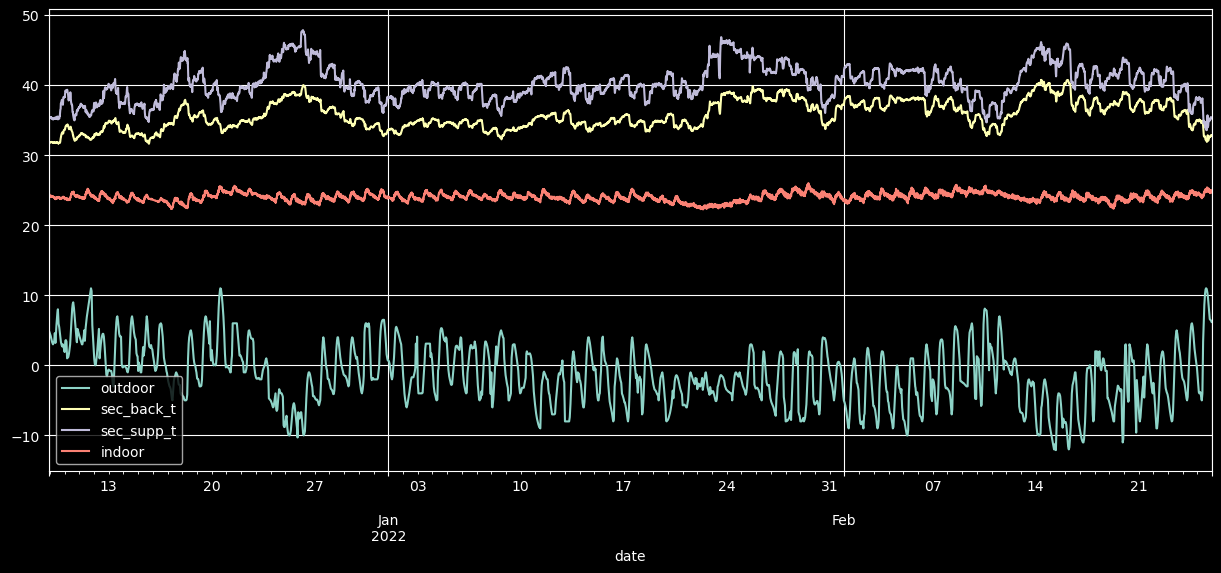

In [4]:
train_data[['outdoor', 'sec_back_t', 'sec_supp_t', 'indoor']].plot(
    figsize=(15, 6), 
    grid=True
)
train_data.head()

### Split

In [5]:
def train_val_split(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        
    # train val split
    train_idx = (X.index <= '2021-12-20') | \
                (X.index >= '2022-1-1') & (y.index <= '2022-1-20') | \
                (X.index >= '2022-2-1') & (y.index <= '2022-2-20')
    val_idx =  ~train_idx

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]

    return X_train, y_train, X_val, y_val

X_indoor = train_data.drop(columns=['indoor'])
y_indoor = train_data[['indoor']]

X_sec_back_t = train_data.drop(columns=['sec_back_t', 'indoor'])
y_sec_back_t = train_data[['sec_back_t']]

X_indoor, y_indoor, \
X_sec_back_t, y_sec_back_t, \
X_indoor_train, y_indoor_train, \
X_indoor_val, y_indoor_val, \
X_sec_back_t_train, y_sec_back_t_train, \
X_sec_back_t_val, y_sec_back_t_val = \
    map(lambda x: torch.tensor(x.values, dtype=torch.float32), 
        (X_indoor, y_indoor, X_sec_back_t, y_sec_back_t) + \
        train_val_split(X_indoor, y_indoor) + \
        train_val_split(X_sec_back_t, y_sec_back_t)
    )

indoor_train_dataset = TensorDataset(X_indoor_train, y_indoor_train)
indoor_val_dataset = TensorDataset(X_indoor_val, y_indoor_val)
sec_back_t_train_dataset = TensorDataset(X_sec_back_t_train, y_sec_back_t_train)    
sec_back_t_val_dataset = TensorDataset(X_sec_back_t_val, y_sec_back_t_val)

indoor_train_dataloader = DataLoader(indoor_train_dataset, batch_size=64, shuffle=True)
indoor_val_dataloader = DataLoader(indoor_val_dataset, batch_size=64, shuffle=False)
sec_back_t_train_dataloader = DataLoader(sec_back_t_train_dataset, batch_size=64, shuffle=True)
sec_back_t_val_dataloader = DataLoader(sec_back_t_val_dataset, batch_size=64, shuffle=False)

print(X_indoor_train.shape, y_indoor_train.shape, X_indoor_val.shape, y_indoor_val.shape)


torch.Size([7067, 9]) torch.Size([7067, 1]) torch.Size([4312, 9]) torch.Size([4312, 1])


### Model

In [6]:
class MLPModel(pl.LightningModule):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        self.save_hyperparameters()

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


sec_back_t_model = MLPModel(input_dim=X_sec_back_t_train.shape[1])
indoor_model = MLPModel(input_dim=X_indoor_train.shape[1])

### Train

In [7]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(sec_back_t_model, sec_back_t_train_dataloader, sec_back_t_val_dataloader)


/home/xusj/miniconda3/envs/rl/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/xusj/miniconda3/envs/rl/lib/python3.11/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/3
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/3
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/3
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 3 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name   | Type       | Params
--------------------------------------
0 | linear | Sequential | 698 K 
--------------------------------------
698 K     Trainable params
0         Non-trainable params
698 K     Total params
2.793     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/xusj/miniconda3/envs/rl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/xusj/miniconda3/envs/rl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/xusj/miniconda3/envs/rl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Eval

<Axes: xlabel='date'>

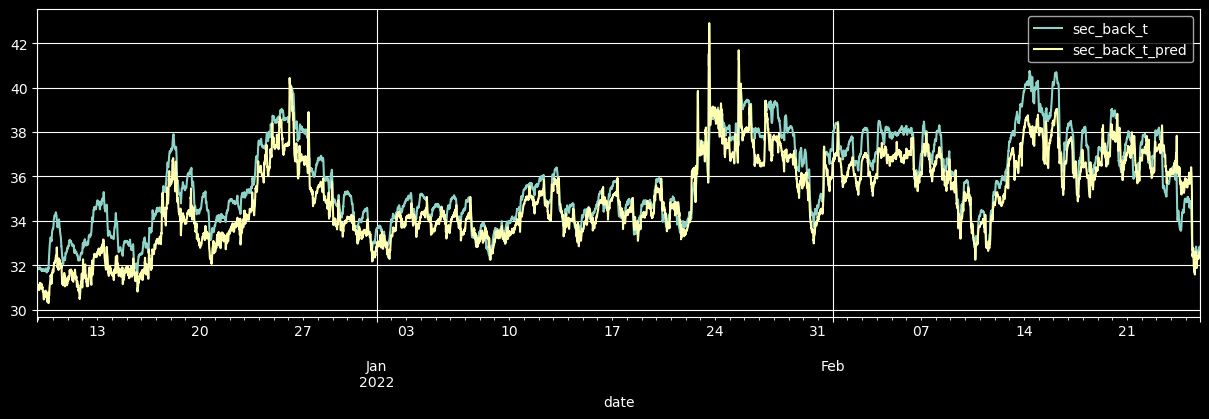

In [15]:
sec_back_t_model.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=999-step=37001.ckpt')

sec_back_t_model.eval()
with torch.no_grad():
    sec_back_t_pred = sec_back_t_model(X_sec_back_t)

pd.DataFrame({
    'sec_back_t': y_sec_back_t.flatten(),
    'sec_back_t_pred': sec_back_t_pred.flatten()
}, index=train_data.index).plot(
    figsize=(15, 4),
    # xlim=('2022-1-1', '2022-1-2'),
    grid=True,
)
